In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt
from tqdm import tqdm
M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
seq_exp = np.load("../test/seq_exp.npy")
seq_partial = seq_exp[:-80]
seq_op = np.load("omega_time_ga_runs/OmegaTimeGA_20260128_173005/gen_045/best_sequence.npy")
zt_freqs = cp.linspace(-40e3, 40e3, 1000)
zt_rabi = 1.01e3
zt_pulse = 500e-6
print(zt_rabi * zt_pulse)

0.505


In [19]:
np.unique(seq_op, axis=0)

array([[ 0.00000000e+00, -3.00000000e+00,  1.76594483e+04,
         8.36717035e-05],
       [ 0.00000000e+00, -2.00000000e+00,  8.60968532e+03,
         1.17046293e-04],
       [ 0.00000000e+00, -1.00000000e+00,  1.36588502e+03,
         2.35755490e-05],
       [ 1.00000000e+00, -3.00000000e+00,  8.27053582e+03,
         1.40830368e-04],
       [ 1.00000000e+00, -2.00000000e+00,  1.22960834e+04,
         1.35644088e-04],
       [ 1.00000000e+00, -1.00000000e+00,  1.24925508e+03,
         2.03690554e-05],
       [ 2.00000000e+00, -5.00000000e+00,  6.87600517e+03,
         7.48209039e-05],
       [ 2.00000000e+00, -4.00000000e+00,  6.87428574e+03,
         9.17299107e-05],
       [ 2.00000000e+00, -3.00000000e+00,  3.54061427e+03,
         2.00092550e-04],
       [ 2.00000000e+00, -2.00000000e+00,  3.54061427e+03,
         1.33420193e-04]])

11it [09:04, 49.49s/it]


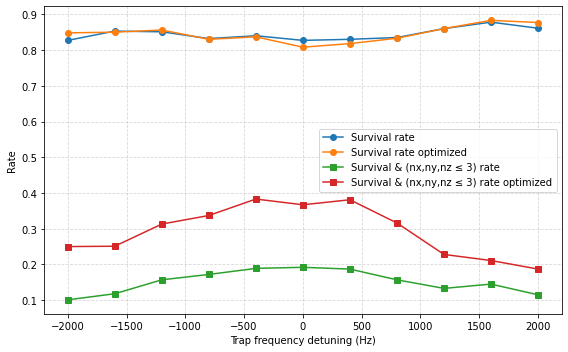

In [4]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm

temp = [25e-6, 25e-6, 25e-6]
trap_dets = np.linspace(-2e3, 2e3, 11)

N_mol = 1000
survival_rate = np.empty(len(trap_dets), dtype=float)
le3_rate = np.empty(len(trap_dets), dtype=float)
survival_rate_op = np.empty(len(trap_dets), dtype=float)
le3_rate_op = np.empty(len(trap_dets), dtype=float)

for i, det in tqdm(enumerate(trap_dets)):
    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_partial,
        res=res,
        trap_detuning=(0, 0, float(det)),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate[i] = float((cp.count_nonzero(le3) / N_mol).get())

    mol_0 = cr.build_thermal_molecules_gpu(N_mol, temp)

    cr.raman_cool_with_pumping(
        molecules_dev=mol_0,
        pulses_dev=seq_op,
        res=res,
        trap_detuning=(0, 0, float(det)),
        show_progress=False,   # keep False for sweeps
    )

    # Survival definition (matches your bootstrap_stats_from_molecules):
    survived = (mol_0[:, 3] == 1) & (mol_0[:, 4] == 0) & (mol_0[:, 5] == 0)
    survival_rate_op[i] = float((cp.count_nonzero(survived) / N_mol).get())

    # “Rate of molecules with all three motional states <= 3”
    # Interpreting as: fraction of the full initial cohort that both survives AND has nx,ny,nz <= 3
    le3 = survived & (mol_0[:, 0] <= 3) & (mol_0[:, 1] <= 3) & (mol_0[:, 2] <= 3)
    le3_rate_op[i] = float((cp.count_nonzero(le3) / N_mol).get())

plt.figure(figsize=(8, 5))
plt.plot(trap_dets, survival_rate, marker="o", label="Survival rate")
plt.plot(trap_dets, survival_rate_op, marker="o", label="Survival rate optimized")
plt.plot(trap_dets, le3_rate, marker="s", label="Survival & (nx,ny,nz ≤ 3) rate")
plt.plot(trap_dets, le3_rate_op, marker="s", label="Survival & (nx,ny,nz ≤ 3) rate optimized")
plt.xlabel("Trap frequency detuning (Hz)")
plt.ylabel("Rate")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


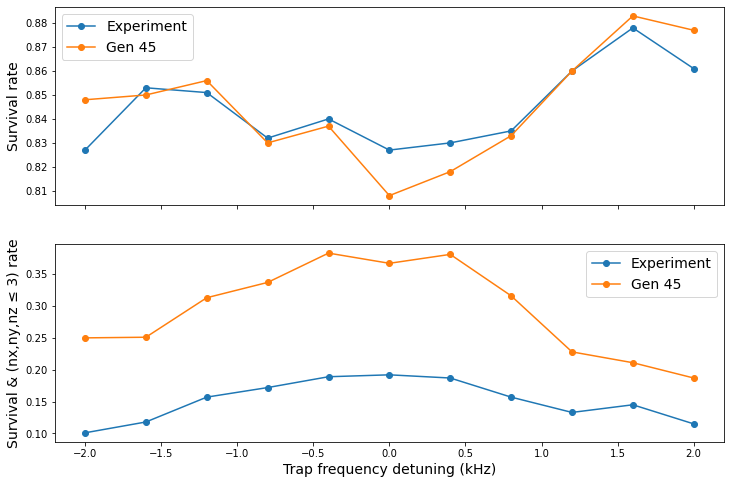

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(trap_dets*1e-3, survival_rate, marker="o", label="Experiment")
ax[0].plot(trap_dets*1e-3, survival_rate_op, marker="o", label="Gen 45")
ax[1].plot(trap_dets*1e-3, le3_rate, marker="o", label="Experiment")
ax[1].plot(trap_dets*1e-3, le3_rate_op, marker="o", label="Gen 45")
ax[1].set_xlabel("Trap frequency detuning (kHz)", fontsize=14)
ax[0].set_ylabel("Survival rate", fontsize=14)
ax[1].set_ylabel("Survival & (nx,ny,nz ≤ 3) rate", fontsize=14)
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)

### Check optimization process

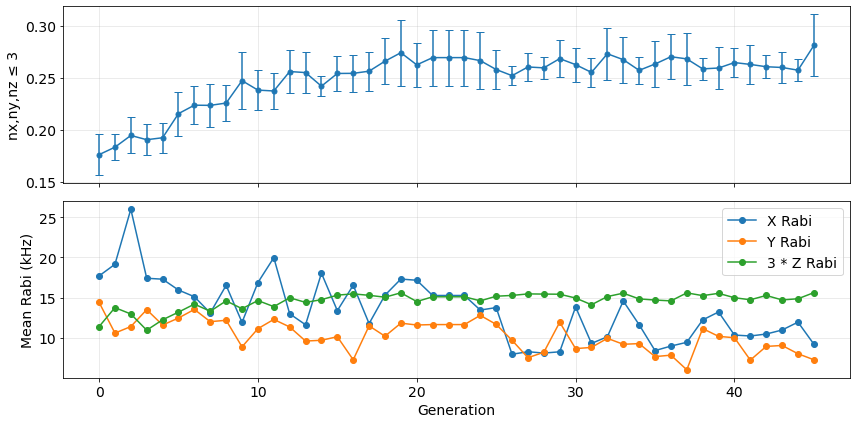

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

base_dir = "omega_time_ga_runs/OmegaTimeGA_20260128_173005"
n_mol = 10_000
gens = []
means = []
stderr = []

x_rabi = []
y_rabi = []
z_rabi = []

for i in range(46):  # 000 to 045 inclusive
    gen_dir = os.path.join(base_dir, f"gen_{i:03d}")
    meta_path = os.path.join(gen_dir, "meta.json")

    if not os.path.isfile(meta_path):
        continue

    with open(meta_path, "r") as f:
        meta = json.load(f)

    scores = np.array(meta["score_list"], dtype=float)
    omega = np.array(meta["omega_vector"], dtype=float)

    gens.append(meta["gen"])
    means.append(scores.mean())
    stderr.append(scores.std(ddof=1) / np.sqrt(len(scores)))

    # Rabi averages
    x_rabi.append(omega[0:3].mean())
    y_rabi.append(omega[3:6].mean())
    z_rabi.append(omega[6:10].mean())

gens = np.array(gens)
means = np.array(means)
stderr = np.array(stderr)

x_rabi = np.array(x_rabi)/1000
y_rabi = np.array(y_rabi)/1000
z_rabi = 3*np.array(z_rabi)/1000

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# ---- Plot 1: mean score ----
ax[0].errorbar(
    gens,
    means/n_mol,
    yerr=stderr/n_mol,
    fmt="o-",
    capsize=4,
    linewidth=1.5,
    markersize=5,
)

ax[0].set_ylabel("nx,ny,nz ≤ 3", fontsize=14)

# ---- Plot 2: Rabi vs generation ----
ax[1].plot(gens, x_rabi, "-o", label="X Rabi")
ax[1].plot(gens, y_rabi, "-o", label="Y Rabi")
ax[1].plot(gens, z_rabi, "-o", label="3 * Z Rabi")

ax[1].set_ylabel("Mean Rabi (kHz)", fontsize=14)
ax[1].set_xlabel("Generation", fontsize=14)
ax[1].legend(fontsize=14)

# ---- Formatting ----
for a in ax:
    a.tick_params(axis="both", labelsize=14)
    a.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()